- Layer（重みを行列にしただけで簡単に動いた）, Networkクラスを実装。
- 8つのパーセプトロン3層でネットワーク構築。
- ニューラルネットの学習では一つの重みが他へ影響を持つ可能性があるので、target_networkを使い分ける。
- 正則化項は下のレイヤーに関しても学習の際は抜けないように気をつけた。

In [14]:
import numpy as np
from numpy.random import rand
from numpy.random import randn
import copy
from matplotlib import pyplot as plt
%matplotlib inline

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Layer:
    def __init__(self, in_size, out_size, _lambda=1.0):
        self._in_size = in_size
        self._out_size = out_size
        self._weight = randn(in_size, out_size)
        self._lambda = _lambda
        self._last_X = None
        self._last_O = None
        
    def forward(self, X):
        self._last_X = X
        self._last_O = sigmoid(np.dot(X, self._weight))
        return self._last_O
    
    # forwardで保持しておいた入力を用いて伝搬された値を掛けて学習
    def backward(self, pt, learning_rate=1e-7):
        self._weight -= np.sum(pt, axis=0) * (np.dot(self._last_X.T, self._last_O * (
            1 - self._last_O)) + self._lambda * 2 * self._weight) * learning_rate
        
    def forward_over_partial_X(self):
        return np.dot(self._last_O * (
            1 - self._last_O), self._weight.T) 

    def nabla_w(self, O):
        return np.dot(self._last_X.T, (2 * (self._last_O - O)) * self._last_O * (
            1 - self._last_O)) + self._lambda * 2 * self._weight
    
    # 勾配確認用
    def numerical_nabla_w(self, O):
        eps = 1e-4
        nabla_w = np.zeros_like(self._weight)
        
        np.sum((self.forward(X) - o_star) ** 2) + \
            self._lambda * np.sum(self._weight ** 2)
        
        for i in range(self._in_size):
            tmp = self._weight[i]
            self._weight[i] = float(tmp) - eps
            lm = self.loss_function(O, X)
            self._weight[i] = float(tmp) + eps
            lp = self.loss_function(O, X)
            nabla_w[i] = (lp - lm) / 2 * eps
            self._weight[i] = tmp
        return nabla_w
    
    def nabla_i(self, O):
        return np.dot(2 * (self._last_O - O) * self._last_O * \
                    (1 - self._last_O), self._weight.T)
        
    def learn(self, O, learning_rate=1e-5):
        self._weight -= self.nabla_w(O) * learning_rate
        # 数値計算版
        # self._weight -= self.numerical_nabla_w(o_star, X) * learning_rate

In [20]:
class Network:
    def __init__(self, layer_count, in_count, out_count, hidden_count):
        assert(layer_count > 2)
        self.layer_count = layer_count
        self.input_layer = Layer(in_count, hidden_count)
        self.hidden_layeres = []
        for i in range(layer_count - 2):
            self.hidden_layeres.append(Layer(hidden_count, hidden_count))
        self.output_layer = Layer(hidden_count, out_count)
        
    def predict(self, X):
        out = self.input_layer.forward(X)
        for i in range(self.layer_count - 2):
            out = self.hidden_layeres[i].forward(out)
        out = self.output_layer.forward(out)
        return out
        
        
    def loss_function(self, X, O):
        out = self.predict(X)
        return np.sum((out - O) ** 2)
    
    def learn(self, X, O):
        self.output_layer.learn(O)
        di = self.output_layer.nabla_i(O)
        for i in range(self.layer_count - 2):
            self.hidden_layeres[self.layer_count - 3 - i].backward(di)
            di = self.hidden_layeres[self.layer_count - 3 - i].forward_over_partial_X()
        self.input_layer.backward(di)

259.2170974159213
252.1059358946384
250.35217557361247
249.89350074113864
249.77607500687782
249.7509394920681
249.75190293809447
249.75992645177467
249.76810725589525
249.77317122256989


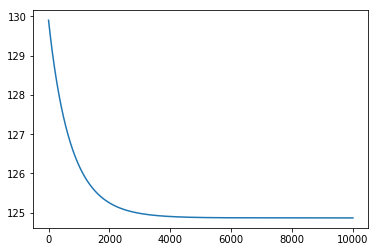

In [24]:
# Xor
# learning_rateを大きくするとすぐに振動する。
# 3層、入力2、出力1、隠れ層のパーセプトロン数2で実装。
# 収束が見られた。
X = rand(1000, 2)
test_X = rand(500, 2)
def Xor(X):
    _X = copy.deepcopy(X.T)
    _X[0] = X.T[0] > 0.5
    _X[1] = X.T[1] > 0.5
    return np.logical_xor(_X[0], _X[1]).astype(float).T.reshape(_X.shape[1], 1)
O = Xor(X)
test_O = Xor(test_X)

def train_network(network, X, O, learning_count=10000):
    learning_step = 0
    loss = np.empty(learning_count)
    while learning_count > learning_step:
        loss[learning_step] = network.loss_function(test_X, test_O)
        print(network.loss_function(X, O)) if learning_step % 1000 == 0 else network.loss_function(X, O)
        network.learn(X, O)   
        learning_step += 1
    plt.plot(loss)

network = Network(3, 2, 1, 2)
train_network(network, X, O)    

In [25]:
import gym, gym.spaces
from copy import deepcopy
from collections import deque
import random

class DQN:
    def __init__(self, env):
        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.memory = deque(maxlen=100000)
        self.gamma = 0.9
        self.epsilon = 1.0
        self.e_decay = 0.9999
        self.e_min = 0.01
        self.learning_rate = 1e-4
        self.model = self.build_network()
        self.target_model = deepcopy(self.model)
        
    def build_network(self):
        # 8層、状態を入力とし、行動価値のベクトルを返す隠れ層のパーセプトロン数が3のネットワーク
        return Network(8, self.state_size,  self.action_size, 3)

    def append_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if self.epsilon >= random.random():
            return self.env.action_space.sample()
        else:
            state_v = np.zeros(self.state_size)
            state_v[state] = 1.0
            return np.amax(self.model.predict(state_v))

    def choose_best_action(self, state):
        return np.amax(self.model.predict(state))

    def replay_experience(self, batch_size):
        batch_size = min(batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)
        X = []
        O = []
        for i in range(batch_size):
            o_star = np.zeros(self.action_size)
            state, action, reward, next_state, done = minibatch[i]
            state_v = np.zeros(self.state_size)
            state_v[state] = 1.0
            if done:
                o_star[action] = reward
            else:
                next_state_v = np.zeros(self.state_size)
                next_state_v[next_state] = 1.0
                o_star[action] = reward + self.gamma * max(self.model.predict(next_state_v))
            X.append(state_v)
            O.append(o_star)
        X = np.array(X)
        O = np.array([O]).T
        self.model.learn(X, O)
        if self.epsilon > self.e_min:
            self.epsilon *= self.e_decay

In [26]:
from IPython.display import display
import ipywidgets as widgets
dqn_player = DQN(gym.make('FrozenLake-v0'))
episodes_c = 20000
batch_size = 32
rewards_per_episode = []
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
        dqn_player.append_memory(pre_state, action, reward, state, done)
        rewards_per_episode.append(total_reward)
    dqn_player.replay_experience(batch_size)
    if e % 1000 == 0:
        print(total_reward)
        dqn_taxi_driver.model = dqn_taxi_driver.target_model
        
fp.close()
plt.plot(rewards_per_episode)

[2018-11-30 22:08:34,752] Making new env: FrozenLake-v0


FloatProgress(value=0.0, max=20000.0)

ValueError: shapes (2,1000) and (4,16,4) not aligned: 1000 (dim 1) != 16 (dim 1)

In [29]:
np.sum(randn(1000,2), axis=0).shape

(2,)

257.58368301782036
勾配確認： -35.45672889406397
253.7627563658062
勾配確認： -18.394528703392176
252.4692906730816
勾配確認： -9.456489612958753
251.86818764495854
勾配確認： -4.954178016574955
251.48083445767728
勾配確認： -2.6917486677838345
251.18360540917934
勾配確認： -1.5428226485071441
250.9409692923102
勾配確認： -0.9469811402427126
250.73944940489005
勾配確認： -0.6271863082459084
250.57152120896313
勾配確認： -0.446654918527464
250.43166652353523
勾配確認： -0.3377742134749706
300.0487808620884
勾配確認： 80.8480758249896
271.35449601440473
勾配確認： 66.73067050335463
256.4162281215529
勾配確認： 41.088805124207575
251.5558241645657
勾配確認： 21.41534681966571
250.28431705216505
勾配確認： 10.503362879666454
249.96448962393322
勾配確認： 5.042438121730006
249.8757972441372
勾配確認： 2.3939566051192775
249.84340451683823
勾配確認： 1.1237820477801101
249.82610785416608
勾配確認： 0.5182061555734641
249.81404486620934
勾配確認： 0.2310722172237678
251.8791748584252
勾配確認： -3.1121316729890802
251.30869976737165
勾配確認： -1.5773404335067385
250.90019583752417
勾配確認： -0.826961995

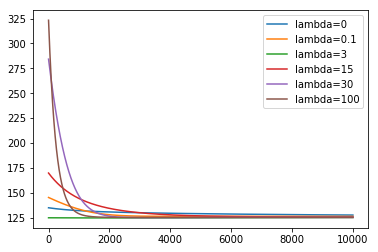

In [3]:
import gym, gym.spaces
from copy import deepcopy
from collections import deque
import random

class DQN:
    def __init__(self, env):
        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.memory = deque(maxlen=100000)
        self.gamma = 0.9
        self.epsilon = 1.0
        self.e_decay = 0.9999
        self.e_min = 0.01
        self.learning_rate = 1e-4
        self.model = self.build_network()
        self.target_model = deepcopy(self.model)
        
    def build_network(self):
        hidden_p_c_p_l = 3
        output_perceptron = Perceptron(hidden_p_c_p_l)
        layer_one = [Perceptron(hidden_p_c_p_l) for i in range(hidden_p_c_p_l)]
        layer_two = [Perceptron(hidden_p_c_p_l) for i in range(hidden_p_c_p_l)]
        layer_three = [Perceptron(hidden_p_c_p_l) for i in range(hidden_p_c_p_l)]
        layer_four = [Perceptron(hidden_p_c_p_l) for i in range(hidden_p_c_p_l)]
        layer_five = [Perceptron(hidden_p_c_p_l) for i in range(hidden_p_c_p_l)]
        layer_six = [Perceptron(hidden_p_c_p_l) for i in range(hidden_p_c_p_l)]
        layer_seven = [Perceptron(hidden_p_c_p_l) for i in range(hidden_p_c_p_l)]
        layer_eight = [Perceptron(self.state_size + self.action_size) for i in range(hidden_p_c_p_l)]
        return [output_perceptron, layer_one, layer_two, layer_three, layer_four]
    
    def predict(self, X):
        out_one = np.array([p.forward(X).flatten() for p in self.model[8]])
        out_two = np.array([p.forward(out_one.T).flatten() for p in self.model[7]])
        out_three = np.array([p.forward(out_two.T).flatten() for p in self.model[6]])
        out_four = np.array([p.forward(out_three.T).flatten() for p in self.model[5]])
        out_five = np.array([p.forward(out_three.T).flatten() for p in self.model[4]])
        out_six = np.array([p.forward(out_three.T).flatten() for p in self.model[3]])
        out_seven = np.array([p.forward(out_three.T).flatten() for p in self.model[2]])
        out_eight = np.array([p.forward(out_three.T).flatten() for p in self.model[1]])
        out = self.model[0].forward(out_four.T)
        return out

    def network_loss_function(self, O, X):
        out = self.predict(X)
        return np.sum((out - O) ** 2)
    
    def train_network(self, X, O, learning_count=100):
        rate = 1e-5
        learning_step = 0
        loss = np.empty(learning_count)
        while learning_count > learning_step:
            self.predict(X)
                
            # 汎用的なループに変更
            for li, l in enumerate(self.target_model):
                if li == 0:
                    l.learn(O, l._last_X, learning_rate=rate)
                    nabla_x = np.sum(l.nabla_i(O, l._last_X), axis=0).flatten()
                    nabla_x_2 = 0
                else:
                    for pi, p in enumerate(l):
                        p.backward(nabla_x[pi], learning_rate=rate)
                        nabla_x_2 += np.sum(p.forward_over_partial_X(), axis=0).flatten()
                    nabla_x = nabla_x_2
                    nabla_x_2 = 0
            
            
            learning_step += 1

    def append_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if self.epsilon >= random.random():
            return self.env.action_space.sample()
        else:
            return self.choose_best_action(state)

    def choose_best_action(self, state):
        best_actions = []
        max_act_value = -100
        for a in range(self.action_size):
            s_a = np.zeros(self.state_size + self.action_size)
            s_a[state] = 1.0
            s_a[self.state_size + a] = 1.0
            act_value = self.predict(s_a)
            if act_value > max_act_value:
                best_actions = [a]
                max_act_value = act_value
            elif act_value == max_act_value:
                best_actions.append(a)
        return random.choice(best_actions)

    def replay_experience(self, batch_size):
        batch_size = min(batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)
        X = []
        O = []
        for i in range(batch_size):
            state, action, reward, next_state, done = minibatch[i]
            s_a = np.zeros(self.state_size + self.action_size)
            s_a[state] = 1.0
            s_a[action] = 1.0
            if done:
                target_f = reward
            else:
                next_rewards = []
                for a in range(self.action_size):
                    next_s_a = np.zeros(self.state_size + self.action_size)
                    next_s_a[next_state] = 1.0
                    next_s_a[self.state_size + a] = 1.0
                    next_rewards.append(self.predict(next_s_a))
                np_n_r_max = np.amax(np.array(next_rewards))
                target_f = reward + self.gamma * np_n_r_max
            X.append(s_a)
            O.append(target_f)
        X = np.array(X)
        O = np.array([O]).T
        self.train_network(X, O)
        if self.epsilon > self.e_min:
            self.epsilon *= self.e_decay

In [ ]:
from IPython.display import display
import ipywidgets as widgets
dqn_taxi_driver = DQN(gym.make('FrozenLake-v0'))
episodes_c = 20000
batch_size = 32
rewards_per_episode = []
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_taxi_driver.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_taxi_driver.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_taxi_driver.env.step(action)
        total_reward += reward
        dqn_taxi_driver.append_memory(pre_state, action, reward, state, done)
        rewards_per_episode.append(total_reward)
    dqn_taxi_driver.replay_experience(batch_size)
    if e % 1000 == 0:
        print(total_reward)
        dqn_taxi_driver.model = dqn_taxi_driver.target_model
        
fp.close()
plt.plot(rewards_per_episode)